In [1]:
%load_ext autoreload
%autoreload 2

#from behav import plotting, utils, loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
pd.set_option('display.max_columns', 500)
import seaborn as sns

from matplotlib import rcParams
#rcParams['font.family'] = 'Arial'

from cdcp.experiment_info import subjects
from cdcp.paths import DATA_PATH_MAGPI
from cdcp.behavior.data import prepare_behavior_data
from cdcp.visualization.colors import colors
subjects, DATA_PATH_MAGPI
from cdcp.paths import DATA_PATH_MAGPI, FIGURE_DIR, ensure_dir
from cdcp.general import save_fig

from cdcp.paths import DATA_PATH_MAGPI, FIGURE_DIR, ensure_dir
from cdcp.general import save_fig

from cdcp.paths import DATA_DIR, ensure_dir

from cdcp.visualization.colors import colors as cdcp_colors

save_figs = True

from cdcp.behavior.data import bin_data, cue_direction

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/general.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
fit_df_interp = pd.read_pickle(DATA_DIR/'behavior'/'fit_df_interp.pickle')
cue_prob_dict = {
    'NC': 0.5,
    'CL0': 0.25,
    'CN': 0.5,
    'CR1': 0.875,
    'CL1': 0.125, 
    'CR0': 0.75
}
fit_df_interp['cue_prob'] = [cue_prob_dict[cue] for cue in fit_df_interp.cue.values]
fit_df_interp['psychometric_inflection'] = fit_df_interp['_inflection']

In [3]:
fit_df_interp[:3]

,bird,cue,interp,n_points,_min,_max,_inflection,_slope,model,y_interp,r_squared,cue_prob,psychometric_inflection
0,B1174,NC,AE,14538,0.112693,0.903653,64.036638,14.918588,<lmfit.minimizer.MinimizerResult object at 0x7...,"[0.11269340812421869, 0.11269340812421869, 0.1...",0.538664,0.50,64.036638
1,B1174,CL0,AE,6876,0.099140,0.880312,64.357732,27.363792,<lmfit.minimizer.MinimizerResult object at 0x7...,"[0.09913953431260725, 0.09913953431260725, 0.0...",0.533202,0.25,64.357732
2,B1174,CN,AE,1606,0.131581,0.884359,64.226503,24.816837,<lmfit.minimizer.MinimizerResult object at 0x7...,"[0.1315810264285665, 0.1315810264285665, 0.131...",0.519944,0.50,64.226503


In [4]:
df = fit_df_interp[['bird', 'psychometric_inflection', 'cue_prob']]
df[:3]

,bird,psychometric_inflection,cue_prob
0,B1174,64.036638,0.50
1,B1174,64.357732,0.25
2,B1174,64.226503,0.50


### Test whether inflection point shifts with cue probability

In [5]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [9]:
# Mixed Linear Model
model = smf.mixedlm("psychometric_inflection ~ cue_prob", df, groups=df["bird"], re_formula="1 + cue_prob")
result = model.fit()

In [10]:
# Summary of the model
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:            MixedLM Dependent Variable: psychometric_inflection
No. Observations: 1050    Method:             REML                   
No. Groups:       20      Scale:              31.1758                
Min. group size:  24      Log-Likelihood:     -3318.5947             
Max. group size:  54      Converged:          Yes                    
Mean group size:  52.5                                               
---------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------
Intercept                 70.075    0.774 90.526 0.000  68.558 71.592
cue_prob                 -11.117    1.158 -9.601 0.000 -13.387 -8.848
Group Var                  9.140    0.706                            
Group x cue_prob Cov     -11.589    0.999                            
cue_prob Var              17.902    1.569                            
=====================================================================

"""

### Test whether the magnitude of the inflection point shift increases with cue probability

In [11]:
inflection_shift_df = pd.DataFrame(columns = ['bird', 'interp', 'slope', 'inflection_shift'])
for bird in fit_df_interp.bird.unique():
    for interp in fit_df_interp.interp.unique():
        bird_interp_fit_df = fit_df_interp[(fit_df_interp.bird==bird) & (fit_df_interp.interp==interp)]
        if len(bird_interp_fit_df) < 5:
            continue
        slope = bird_interp_fit_df[bird_interp_fit_df.cue == 'NC']._slope.values[0]
        left_inflection = np.mean(bird_interp_fit_df[bird_interp_fit_df.cue.isin(['CL0', 'CL1'])]._inflection.values)
        right_inflection = np.mean(bird_interp_fit_df[bird_interp_fit_df.cue.isin(['CR0', 'CR1'])]._inflection.values)
        inflection_shift = left_inflection - right_inflection  
        inflection_shift_df.loc[len(inflection_shift_df)] = [
            bird, interp, slope, inflection_shift
        ]

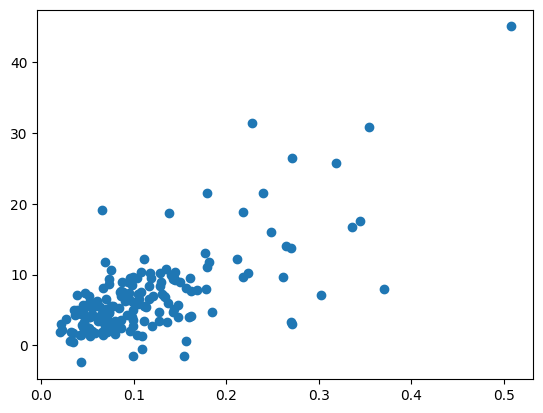

In [12]:
plt.scatter(1 / inflection_shift_df.slope, inflection_shift_df.inflection_shift)

In [21]:
inflection_shift_df['inverse_slope'] = 1 / inflection_shift_df.slope

In [30]:
df = inflection_shift_df[['bird', 'inverse_slope', 'inflection_shift', 'slope']]

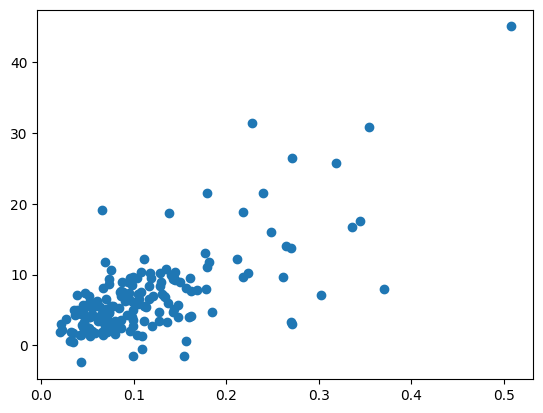

In [26]:
plt.scatter(df.inverse_slope, inflection_shift_df.inflection_shift)

In [33]:
# Mixed Linear Model
model = smf.mixedlm("inflection_shift ~ slope", df, groups=df["bird"], re_formula="1 + slope")
result = model.fit()

In [34]:
# Summary of the model
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: inflection_shift
No. Observations: 175     Method:             REML            
No. Groups:       20      Scale:              18.7350         
Min. group size:  4       Log-Likelihood:     -523.7910       
Max. group size:  9       Converged:          Yes             
Mean group size:  8.8                                         
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept           11.419    1.624  7.032 0.000  8.237 14.602
slope               -0.401    0.099 -4.035 0.000 -0.596 -0.206
Group Var           41.635    4.018                           
Group x slope Cov   -2.350    0.235                           
slope Var            0.133    0.014                           
==============================================================

"""